## Assignment 2

In [1]:
# Importing the necessary Libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

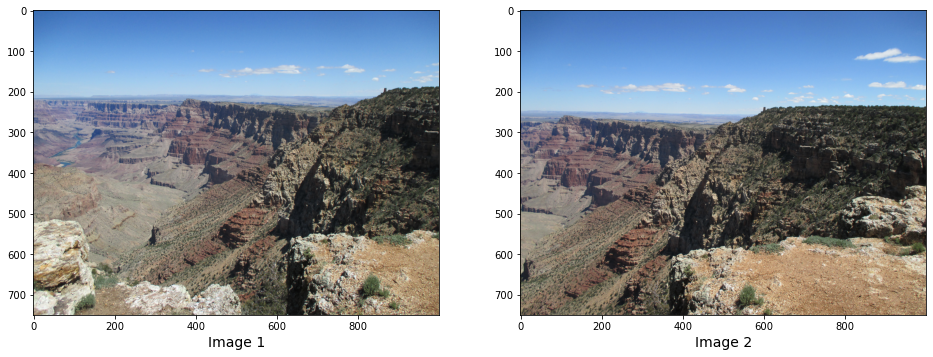

In [2]:
# Reading the images and displaying them

image1 = imageio.imread('left_img.png')
image1Gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

image2 = imageio.imread('right_img.png')
image2Gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(image1, cmap="gray")
ax1.set_xlabel("Image 1", fontsize=14)

ax2.imshow(image2, cmap="gray")
ax2.set_xlabel("Image 2", fontsize=14)

plt.show()

In [3]:
# Extracting the local invariant descriptors using SIFT

descriptor = cv2.xfeatures2d.SIFT_create()
kpsA, featuresA = descriptor.detectAndCompute(image1Gray, None)
kpsB, featuresB = descriptor.detectAndCompute(image2Gray, None)

Detecting Key points


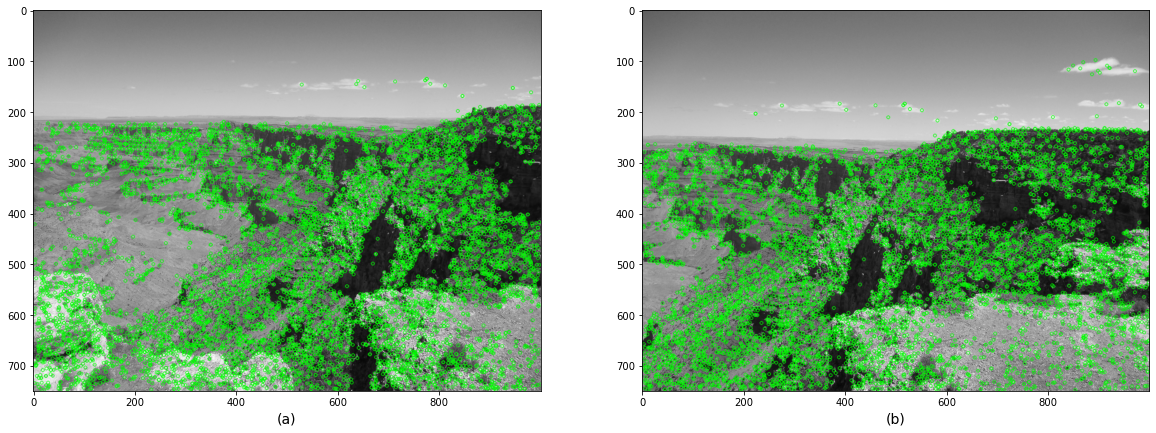

In [4]:
# Detecting the key points in both the images

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1Gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2Gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)
print('Detecting Key points')
plt.show()

In [5]:
# Using the KNN feature matcher for matching the relevant features in both images

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
rawMatches = bf.knnMatch(featuresA, featuresB, 2)
print("Raw matches (KNN):", len(rawMatches))
matches = []
ratio = 0.75
for m,n in rawMatches:
    if m.distance < n.distance * ratio:
        matches.append(m)

Raw matches (KNN): 8039


Using: KNN feature matcher


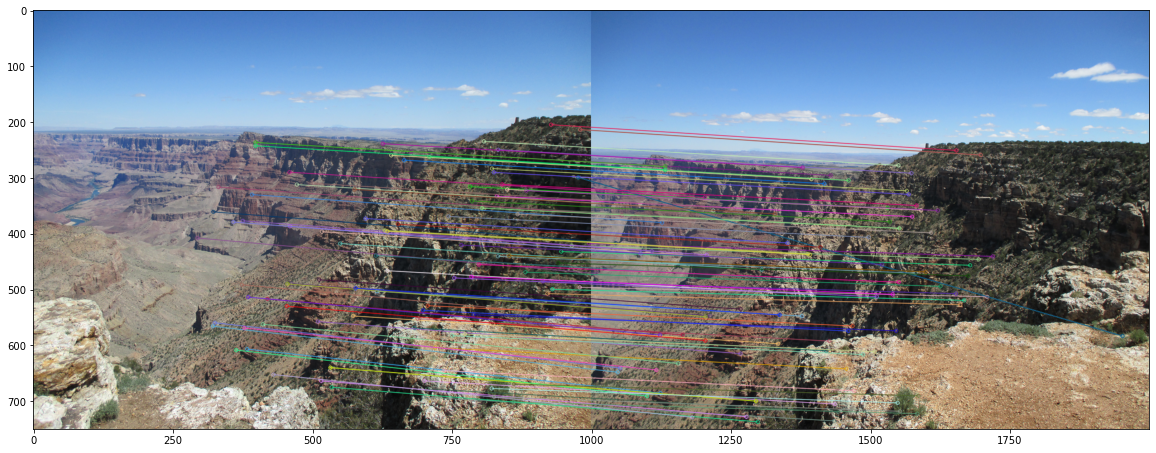

In [6]:
# Finding the distance between the features that match

print("Using: KNN feature matcher")

fig = plt.figure(figsize=(20,8))
image3 = cv2.drawMatches(image1,kpsA,image2,kpsB,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(image3)
plt.show()

In [7]:
# Running RANSAC to estimate the homography matrix

kpsA = np.float32([kp.pt for kp in kpsA])
kpsB = np.float32([kp.pt for kp in kpsB])

if len(matches) > 4:
    ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

    (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)

print("Homography Matrix")
print(H)

Homography Matrix
[[ 1.38259230e+00  1.97643299e-02 -4.04811170e+02]
 [ 1.08698641e-01  1.20112774e+00 -8.41669262e+00]
 [ 3.92447657e-04 -6.33686201e-05  1.00000000e+00]]


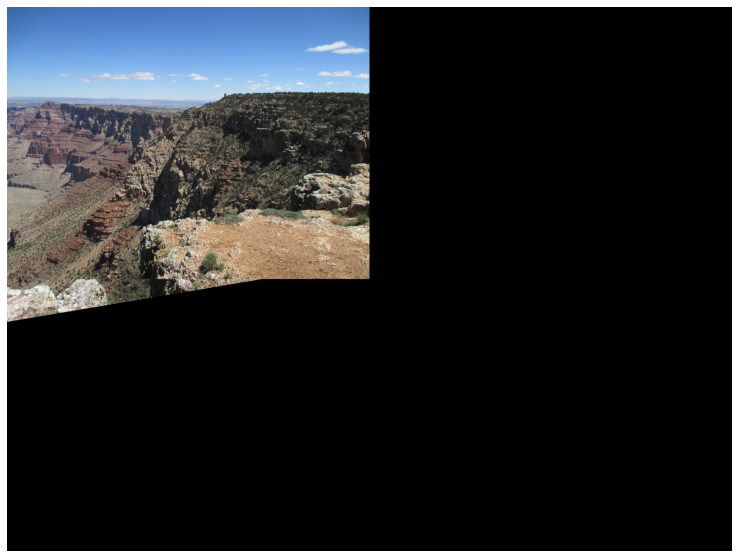

In [8]:
# Displaying the attached image

width = image1.shape[1] + image2.shape[1]
height = image1.shape[0] + image2.shape[0]

result = cv2.warpPerspective(image1, H, (width, height))
result[0:image2.shape[0], 0:image2.shape[1]] = image2

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

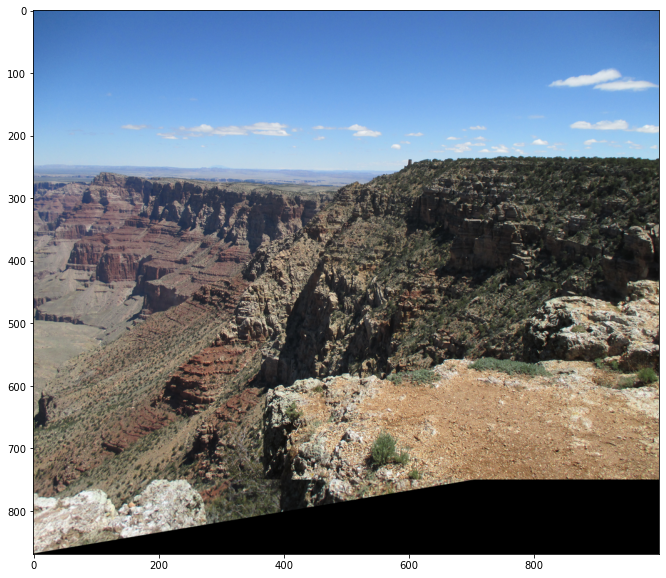

In [9]:
# Cropping the image to remove the black part

gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)
result = result[y:y + h, x:x + w]

plt.figure(figsize=(20,10))
plt.imshow(result)